# Testing LOSD
### Bevölkerung nach Konfession, seit 1934

Wirtschaftliche Wohnbevölkerung der Stadt Zürich nach Religion und Jahr, seit 1934.

https://data.integ.stadt-zuerich.ch/dataset/bev316od3160

Datum: 15.03.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DonGoginho/colab/blob/main/losd/3160_losd_bev_bestand_jahr_konfession_od3160.ipynb)


### Importiere die notwendigen Packages

In [21]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly

In [22]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

In [23]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [24]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [25]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Setze einige Pfadvariabeln

**BITTE HIER ANPASSEN**

In [26]:
package_name = "bev316od3160"
package_name = package_name.upper()
print(package_name)

BEV316OD3160


In [27]:
dataset_name = "bev316od3160.csv"

**Statische Pfade CKAN-URLs**

In [28]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/"
ld_integ_url ="https://ld.integ.stadt-zuerich.ch/statistics/view/"

In [29]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"
ld_prod_url ="https://ld.stadt-zuerich.ch/statistics/view/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [30]:
from IPython.display import Markdown as md

In [31]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name.lower()))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bev316od3160 

In [32]:
md(" **2. Dataset auf INTEG-LD:** Link {} ".format(ld_integ_url+package_name.upper()))

 **2. Dataset auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/BEV316OD3160 

In [33]:
md(" **3. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name.lower()))

 **3. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev316od3160 

In [34]:
md(" **4. Dataset auf PROD-LD:** Link {} ".format(ld_prod_url+package_name.upper()))

 **4. Dataset auf PROD-LD:** Link https://ld.stadt-zuerich.ch/statistics/view/BEV316OD3160 

### Setze ein paar Zeitvariabeln
Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe [Link](https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime)
Zuerst die Zeitvariabeln als Strings

In [35]:
now = datetime.date.today()
year_today = now.strftime("%Y")

Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [36]:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Importiere den Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [37]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

int - web


In [38]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            #fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = ckan_prod_url+package_name+'/download/'+dataset_name
        fp = ld_prod_url+package_name+'/observation?format=csv'
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        #fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = ckan_integ_url+package_name+'/download/'+dataset_name
        fp = ld_integ_url+package_name+'/observation?format=csv'
        print("fp lautet:"+fp)


fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/BEV316OD3160/observation?format=csv


In [39]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['ZEIT_lang']
        ,low_memory=False)
    print("web")

data2betested.dtypes
#data2betested.sort_values("ZEIT_lang", ascending=True)

ProxyError: HTTPSConnectionPool(host='ld.integ.stadt-zuerich.ch', port=443): Max retries exceeded with url: /statistics/view/BEV316OD3160/observation?format=csv (Caused by ProxyError('Cannot connect to proxy.', OSError('Tunnel connection failed: 407 authenticationrequired')))

In [ ]:
data2betested.sort_values("ZEIT_lang", ascending=False).head(2)

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,KON_lang,KON_code,BEW
52,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,"Andere, ohne, unbekannt",KON9900,275174
157,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,Römisch-katholische Kirche,KON2001,97639


Berechne weitere Attribute falls notwendig

`ACHTUNG`!

In Pandas kann `datetime` Daten ab dem Jahr **1677** speichern. Das liegt daran, dass Pandas datetime64[ns] auf der Basis von NumPy verwendet, das wiederum den Datentyp datetime64 bereitstellt, der auf dem Standard des Proleptischen Gregorianischen Kalenders basiert. Dieser Kalender geht bis zum Jahr 1677 zurück.

Alternative: Abfangen des Problems mit Funktion:

-----------------------------------------------

In [ ]:
def convert_to_datetime(date_str):
    try:
        date = pd.to_datetime(date_str)
        if date.year < 1677:
            raise ValueError("Datum liegt außerhalb des gültigen Bereichs für datetime-Objekte.")
        return date
    except ValueError:
        return pd.NaT  # Falls ein ungültiges Datum übergeben wurde, gib NaT (Not a Timestamp) zurück


-------------------------------------------------------

In [ ]:
data2betested = (
    data2betested
    .copy()
    .assign(
        StichtagDatJahr = lambda x: x.ZEIT_lang.apply(convert_to_datetime),
        #StichtagDatJahr = lambda x: x.ZEIT_lang,
        StichtagDatJahr_str = lambda x: x.ZEIT_lang.astype(str),
        #Jahr = lambda x: x.ZEIT_lang.dt.year,
        Jahr_nbr = lambda x: x.ZEIT_code.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.RAUM_code.str[1:].astype(int),

    )
    .sort_values('ZEIT_lang', ascending=False)
    )
data2betested

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,KON_lang,KON_code,BEW,StichtagDatJahr,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
52,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,"Andere, ohne, unbekannt",KON9900,275174,2023-12-31,2023-12-31,2023,30000
157,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,Römisch-katholische Kirche,KON2001,97639,2023-12-31,2023-12-31,2023,30000
258,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,74269,2023-12-31,2023-12-31,2023,30000
40,2022-12-31,Z31122022,Stadt Zürich (ab 1934),R30000,Römisch-katholische Kirche,KON2001,102074,2022-12-31,2022-12-31,2022,30000
204,2022-12-31,Z31122022,Stadt Zürich (ab 1934),R30000,"Andere, ohne, unbekannt",KON9900,263856,2022-12-31,2022-12-31,2022,30000
...,...,...,...,...,...,...,...,...,...,...,...
116,1934-12-31,Z31121934,Stadt Zürich (ab 1934),R30000,Römisch-katholische Kirche,KON2001,92740,1934-12-31,1934-12-31,1934,30000
240,1930-12-31,Z31121930,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,189773,1930-12-31,1930-12-31,1930,30000
2,1920-12-31,Z31121920,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,155027,1920-12-31,1920-12-31,1920,30000
25,1910-12-31,Z31121910,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,139649,1910-12-31,1910-12-31,1910,30000


Minimales und maximales Jahr im Datensatz

In [ ]:
data_max_date = str(max(data2betested.StichtagDatJahr).year)
data_min_date = str(min(data2betested.StichtagDatJahr).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")

Die Daten haben ein Minimumjahr von 1900 und ein Maximumjahr von 2023


Zeitbereich aus den Daten:

In [ ]:
data_max_date = str(max(data2betested.Jahr_nbr))

try:
    if min(data2betested.Jahr_nbr) < 1678:
        data_min_date="1688"
    else:
        data_min_date = str(min(data2betested.Jahr_nbr))
except ValueError:
    print("Fehler...")

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von 1900 und ein Maximumjahr von 2023


### Einfache Datentests

In [ ]:
data2betested.head(2).T

,52,157
ZEIT_lang,2023-12-31 00:00:00,2023-12-31 00:00:00
ZEIT_code,Z31122023,Z31122023
RAUM_lang,Stadt Zürich (ab 1934),Stadt Zürich (ab 1934)
RAUM_code,R30000,R30000
KON_lang,"Andere, ohne, unbekannt",Römisch-katholische Kirche
KON_code,KON9900,KON2001
BEW,275174,97639
StichtagDatJahr,2023-12-31 00:00:00,2023-12-31 00:00:00
StichtagDatJahr_str,2023-12-31,2023-12-31
Jahr_nbr,2023,2023


In [ ]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274 entries, 52 to 142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ZEIT_lang            274 non-null    datetime64[ns]
 1   ZEIT_code            274 non-null    object        
 2   RAUM_lang            274 non-null    object        
 3   RAUM_code            274 non-null    object        
 4   KON_lang             274 non-null    object        
 5   KON_code             274 non-null    object        
 6   BEW                  274 non-null    float64       
 7   StichtagDatJahr      274 non-null    datetime64[ns]
 8   StichtagDatJahr_str  274 non-null    object        
 9   Jahr_nbr             274 non-null    int32         
 10  RAUM_my_sort         274 non-null    int32         
dtypes: datetime64[ns](2), float64(1), int32(2), object(6)
memory usage: 132.3 KB


In [ ]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 274 rows (observations) and 11 columns (variables).
There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei BEW?

In [ ]:
data2betested[np.isnan(data2betested.BEW)]

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,KON_lang,KON_code,BEW,StichtagDatJahr,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [ ]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [ ]:
data2betested.index.year.unique()


Int64Index([1900, 1910, 1920, 1930, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
            1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
            1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
            1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
            2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
            2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
           dtype='int64', name='StichtagDatJahr')

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [ ]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,KON_lang,KON_code,StichtagDatJahr_str
count,274,274,274,274,274,274,274
unique,NaN,94,1,1,3,3,94
top,NaN,Z31121977,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,1977-12-31
freq,NaN,3,274,274,94,94,3
mean,1978-07-28 03:45:59.124087584,NaN,NaN,NaN,NaN,NaN,NaN
min,1900-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,1955-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,1978-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,2001-09-30 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
max,2023-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


Beschreibe numerische Attribute

In [ ]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,BEW,Jahr_nbr,RAUM_my_sort
count,274,274,274
mean,"128,803","1,978","30,000"
std,"70,991",27,0
min,"13,634","1,900","30,000"
25%,"91,940","1,955","30,000"
50%,"123,694","1,978","30,000"
75%,"163,833","2,001","30,000"
max,"275,174","2,023","30,000"


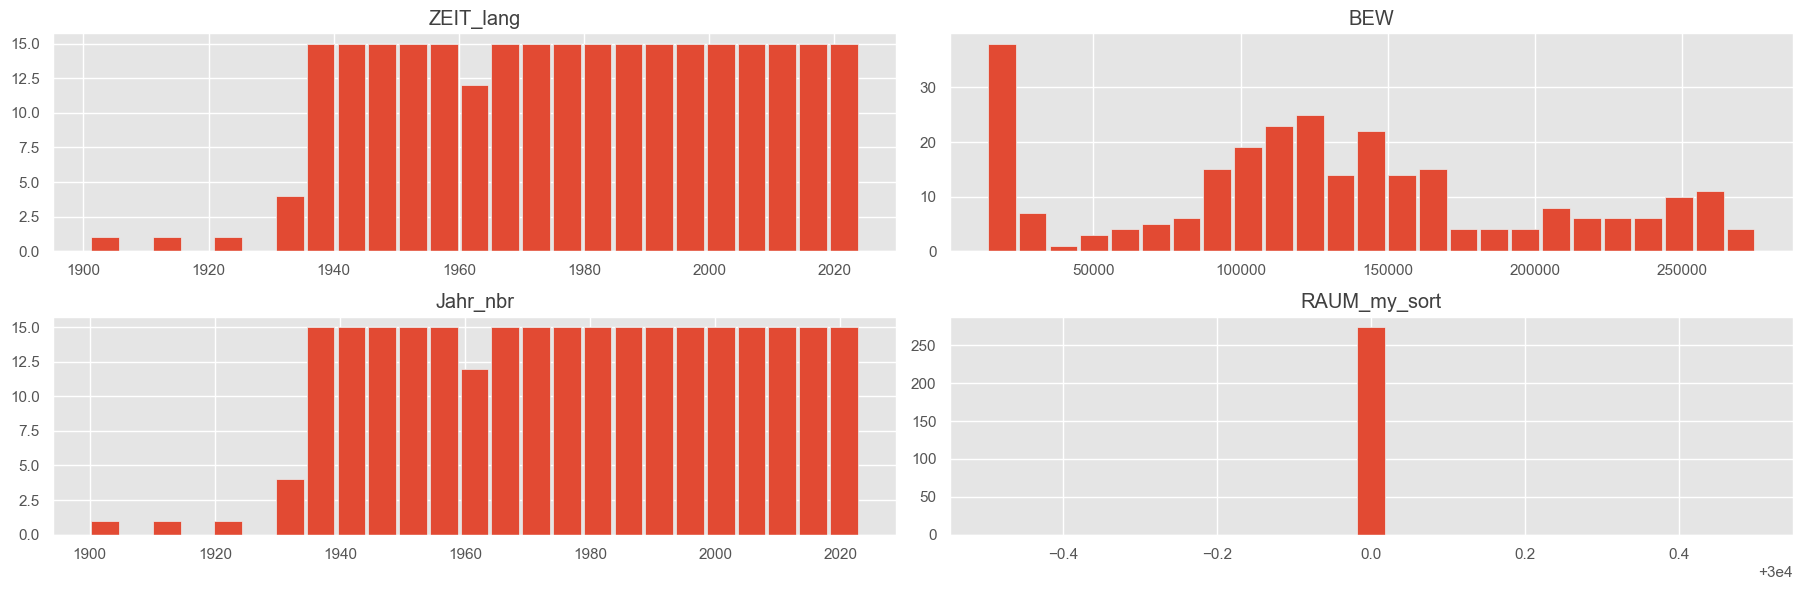

In [ ]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [ ]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,KON_lang,KON_code,BEW,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,


### Nullwerte und Missings?

In [ ]:
data2betested.isnull().sum()

ZEIT_lang              0
ZEIT_code              0
RAUM_lang              0
RAUM_code              0
KON_lang               0
KON_code               0
BEW                    0
StichtagDatJahr_str    0
Jahr_nbr               0
RAUM_my_sort           0
dtype: int64

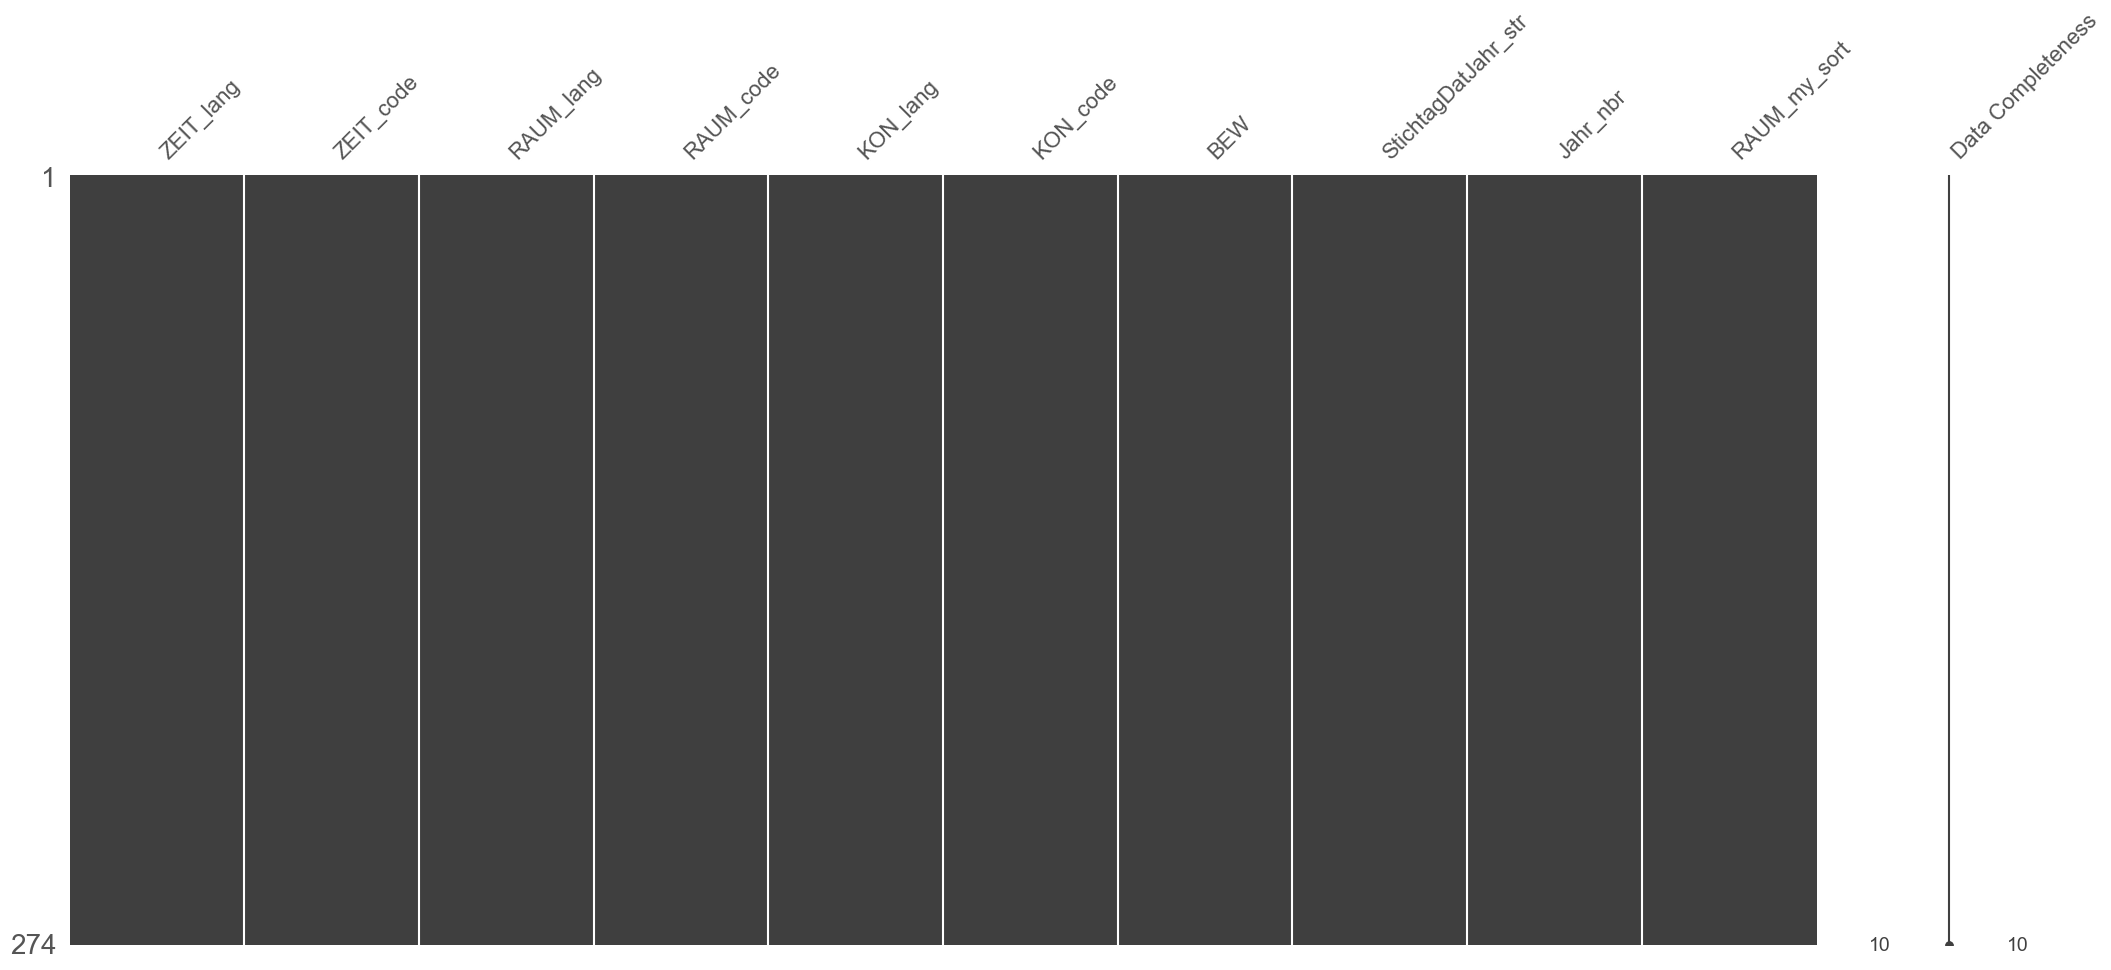

In [ ]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno
msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [ ]:
agg_jahr = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('Jahr_nbr', ascending=False) 
agg_jahr.reset_index().head(3)

,Jahr_nbr,sum_AnzBestWir
0,2023,447082
1,2022,443037
2,2021,436332


In [ ]:
data2betested.RAUM_lang.unique()

array(['Stadt Zürich (ab 1934)'], dtype=object)

In [ ]:
agg_Quarts = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr','RAUM_lang', 'RAUM_code']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values(['Jahr_nbr','RAUM_code'], ascending=[False, True]) 
agg_Quarts.reset_index().head(50)

,Jahr_nbr,RAUM_lang,RAUM_code,sum_AnzBestWir
0,2023,Stadt Zürich (ab 1934),R30000,447082
1,2022,Stadt Zürich (ab 1934),R30000,443037
2,2021,Stadt Zürich (ab 1934),R30000,436332
3,2020,Stadt Zürich (ab 1934),R30000,434736
4,2019,Stadt Zürich (ab 1934),R30000,434008
5,2018,Stadt Zürich (ab 1934),R30000,428737
6,2017,Stadt Zürich (ab 1934),R30000,423310
7,2016,Stadt Zürich (ab 1934),R30000,415682
8,2015,Stadt Zürich (ab 1934),R30000,410404
9,2014,Stadt Zürich (ab 1934),R30000,404783


In [ ]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'KON_lang', 'KON_code', 'BEW',
       'StichtagDatJahr_str', 'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [ ]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,KON_lang,KON_code,BEW,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,
2023-12-31,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,74269,2023-12-31,2023,30000
2023-12-31,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,Römisch-katholische Kirche,KON2001,97639,2023-12-31,2023,30000


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnbevölkerung seit ...

In [ ]:
myAggAll = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAggAll.reset_index().head(30)

,StichtagDatJahr,sum_WBev
0,2023-12-31,447082
1,2022-12-31,443037
2,2021-12-31,436332
3,2020-12-31,434736
4,2019-12-31,434008
5,2018-12-31,428737
6,2017-12-31,423310
7,2016-12-31,415682
8,2015-12-31,410404
9,2014-12-31,404783


In [ ]:
myTitle="Bevölkerungsentwicklung, seit "+data_min_date

highlight = alt.selection(type='single', on='mouseover',
                          fields=['sum_WBev'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAggAll.reset_index().query('sum_WBev>30'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    #, color=alt.Color('QuarLang', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [ ]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'KON_lang', 'KON_code', 'BEW',
       'StichtagDatJahr_str', 'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

In [ ]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2000":data_max_date]\
    .groupby(['StichtagDatJahr','Jahr_nbr', 'RAUM_lang', 'RAUM_code','KON_lang', 'KON_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,Jahr_nbr,RAUM_lang,RAUM_code,KON_lang,KON_code,sum_WBev
0,2000-12-31,2000,Stadt Zürich (ab 1934),R30000,"Andere, ohne, unbekannt",KON9900,124559
1,2000-12-31,2000,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,112513
2,2000-12-31,2000,Stadt Zürich (ab 1934),R30000,Römisch-katholische Kirche,KON2001,123908


In [ ]:
#help(sns.catplot)     

In [ ]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

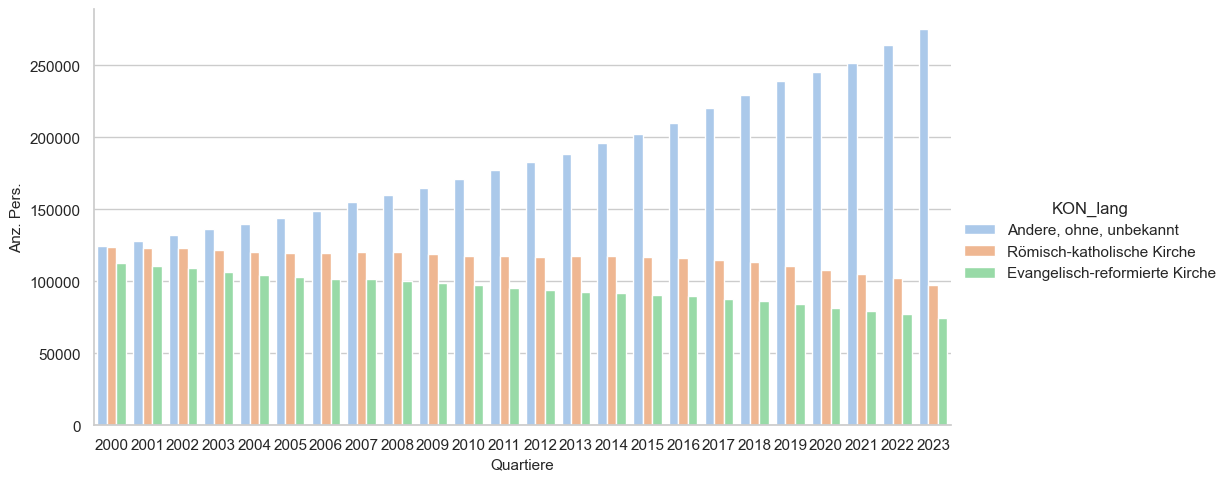

In [ ]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr_nbr"
            , y="sum_WBev"
            , hue="KON_lang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().sort_values("RAUM_code", ascending=True)
           )
myHist.set_xlabels('Quartiere', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


In [ ]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'KON_lang', 'KON_code', 'BEW',
       'StichtagDatJahr_str', 'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

In [ ]:
myAggBar = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr','StichtagDatJahr_str', 'RAUM_lang', 'RAUM_code', 'RAUM_my_sort', 'KON_lang', 'KON_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('RAUM_my_sort', ascending=True) 

myAggBar

sum_WBev
Jahr_nbr StichtagDatJahr_str RAUM_lang              RAUM_code RAUM_my_sort KON_lang                       KON_code          
1900     1900-12-31          Stadt Zürich (ab 1934) R30000    30000        Evangelisch-reformierte Kirche KON1001     116555
1990     1990-12-31          Stadt Zürich (ab 1934) R30000    30000        Evangelisch-reformierte Kirche KON1001     140044
                                                                           Römisch-katholische Kirche     KON2001     140194
1991     1991-12-31          Stadt Zürich (ab 1934) R30000    30000        Andere, ohne, unbekannt        KON9900      87312
                                                                           Evangelisch-reformierte Kirche KON1001     135084
...                                                                                                                      ...
1962     1962-12-31          Stadt Zürich (ab 1934) R30000    30000        Evangelisch-reformierte Kirche KON1001     260218
                                                                           Andere, ohne, unbekannt        KON9900      19134
1961     1961-12-31          Stadt Zürich (ab 1934) R30000    30000        Römisch-katholische Kirche     KON2001     157991
1963     1963-12-31          Stadt Zürich (ab 1934) R30000    30000        Römisch-katholische Kirche     KON2001     161976
2023     2023-12-31          Stadt Zürich (ab 1934) R30000    30000        Römisch-katholische Kirche     KON2001      97639

[274 rows x 1 columns]

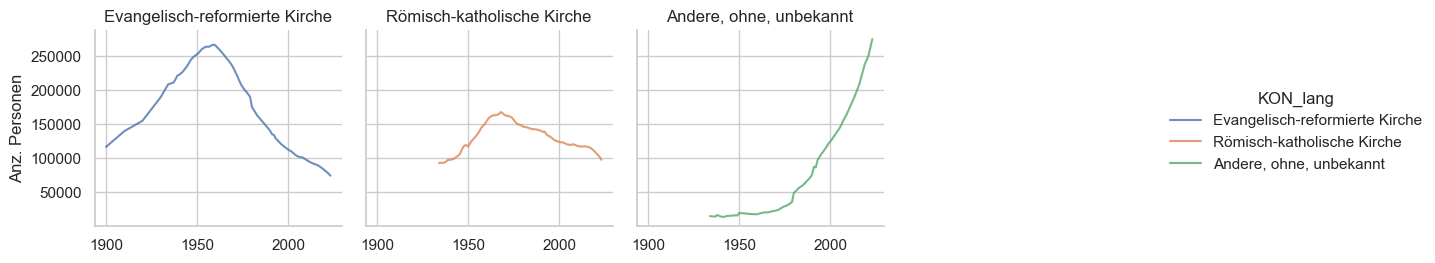

In [ ]:
g2 = sns.FacetGrid(myAggBar.reset_index(), col="KON_lang", hue="KON_lang", col_wrap=4, height=3,)
g2.map(sns.lineplot, "Jahr_nbr","sum_WBev",alpha=.8)

g2.set_axis_labels("","Anz. Personen")
g2.set_titles(col_template="{col_name}", row_template="{row_name}")

g2.add_legend()


## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/OGD%20Metadaten.aspx#InplviewHasheb69a2c0-ed94-4ef2-91a5-3b19f038e442=FilterField1%3DMetadaten%255Fx002d%255FPublikations%255Fx00-FilterValue1%3DINT)